In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, SubsetRandomSampler, DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models 
# from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import pytorch_lightning as pl

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
torch.__version__

'2.5.1'

In [5]:
pl.__version__

'2.5.1.post0'

### Calculating the mean and std dev of the images in the selected dataset

In [6]:
# Define a basic transform just to load data
basic_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()  # Converts to [0, 1]
])

In [7]:
# Setting dataset path
path = "E:\\mini_ImageNet\\archive\\"

In [8]:
dataset = datasets.ImageFolder(path, transform=basic_transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=10)

mean = 0.
std = 0.
nb_samples = 0.

for data, _ in loader:
    #Getting the number of datapoints in this batch
    batch_samples = data.size(0)
    
    #Reshaping the tensor; tensors with shape (batch_size, channels, height, width) will have the shape (batch_size, channels, height*width)
    data = data.view(batch_samples, data.size(1), -1)
    
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples
    

mean /= nb_samples
std /= nb_samples

# #Hardcoding the output for faster experiments
# mean = [0.4764, 0.4491, 0.4001]
# std = [0.2264, 0.2224, 0.2212]


print("Mean:", mean)
print("Std:", std)

Mean: [0.4764, 0.4491, 0.4001]
Std: [0.2264, 0.2224, 0.2212]


### Image Transforms

In [9]:
transform=transforms.Compose([
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

In [10]:
#Getting class names from the folder names of images
class_names=sorted(os.listdir(path))
class_names = ['_'.join(c.split('_')[:-1]) for c in class_names]

### Data Module

In [11]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size:int=32, num_workers:int=10, transform=transform):
        super().__init__()
        # self.root_dir = "/kaggle/input/miniimagenet"
        self.root_dir = path
        self.transform = transform
        self.batch_size = batch_size
        self.num_w = num_workers

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.7 * n_data)
        n_valid = int(0.2 * n_data)
        n_test = n_data - n_train - n_valid
        
        self.train_dataset, self.val_dataset, self.test_dataset = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])
        
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, 
                  num_workers=self.num_w, persistent_workers=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, 
                  num_workers=self.num_w, persistent_workers=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, 
                  num_workers=self.num_w, persistent_workers=True)
        

### CNN Classifier

In [12]:
class ConvolutionalNetwork(pl.LightningModule):
    
    def __init__(self, class_labels, numChannels:int=3):
        super(ConvolutionalNetwork, self).__init__()
        
        ##Initializing channel sizes for different layers
        
        self.conv1_out_channels = 16
        self.conv2_out_channels = 32
        self.conv3_out_channels = 64
        
        self.fc1_out_features = 512
        self.fc2_out_features = 256
        self.fc3_out_features = len(class_labels)
        
        #Initializing lists to store train and val accuracies and losses
        self.training_accuracies = []
        self.validation_accuracies = []
        self.training_losses = []
        self.validation_losses = []


        #First conv layer block
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=self.conv1_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()          #also try leaky relu
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Second conv layer block
        self.conv2 = nn.Conv2d(in_channels=self.conv1_out_channels, out_channels=self.conv2_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Third conv layer block
        self.conv3 = nn.Conv2d(in_channels=self.conv2_out_channels, out_channels=self.conv3_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        # Flatten
        self.flatten = nn.Flatten()
        
        #Fully connected layers
        self.fc1 = nn.LazyLinear(self.fc1_out_features)    #try bias=True ?
        self.act_fc1 = nn.ReLU()
        
        self.fc2 = nn.Linear(in_features=self.fc1_out_features, out_features=self.fc2_out_features)
        self.act_fc2 = nn.ReLU()
        
        self.fc3 = nn.Linear(in_features=self.fc2_out_features, out_features=self.fc3_out_features)
        self.output_activation  = nn.LogSoftmax(dim=1)
        
    # convolution output size formula: https://i.sstatic.net/vD1u3.png
    
    
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.act3(self.conv3(x))
        x = self.pool3(x)
        
        x = self.flatten(x)
        
        x = self.act_fc1(self.fc1(x))
        x = self.act_fc2(self.fc2(x))
        x = self.output_activation(self.fc3(x))
        
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = (pred.squeeze() == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=False)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = (pred.squeeze() == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=False)
        

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)
        
        
    def on_train_epoch_end(self):
        train_acc = self.trainer.callback_metrics.get("train_acc")
        train_loss = self.trainer.callback_metrics.get("train_loss")
        if train_acc is not None:
            self.training_accuracies.append(train_acc.item())
        if train_loss is not None:
            self.training_losses.append(train_loss.item())
        print(f"\nTrain - After Epoch {self.current_epoch}: loss={train_loss:.3f}, acc={train_acc:.3f}")

    def on_validation_epoch_end(self):
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        if val_acc is not None:
            self.validation_accuracies.append(val_acc.item())
        if val_loss is not None:
            self.validation_losses.append(val_loss.item())
        print(f"\nVal - After Epoch {self.current_epoch}: loss={val_loss:.3f}, acc={val_acc:.3f}")


In [13]:
#Removing the Validation DataLoader progress bar between epochs
class MinimalProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        # Return a dummy tqdm with no visible output to disable validation progress bar
        # Set total=0 to avoid progress display
        return tqdm(disable=True)

    def init_test_tqdm(self):
        # Same for test dataloader
        return tqdm(disable=True)
    

In [14]:
#Getting current timestamp to use in model checkpoints
timestamp = datetime.now().strftime(format="%Y-%m-%d_%H-%M-%S")

In [15]:
#Configuring model checkpointing:
checkpoint_callback = ModelCheckpoint(
    dirpath=f"checkpoints\\{timestamp}",                   # Folder to save checkpoints
    filename=f"epoch{{epoch:02d}}-val_loss{{val_loss:.2f}}", 
    save_top_k=2,                             
    monitor="val_loss",                       # Metric to track best model
    mode="min",                               
    save_weights_only=False                  # Save full model
#     every_n_epochs=5                          # Save every n epochs
)

In [16]:
#Configuring early stopping callback
early_stop_callback = EarlyStopping(
    monitor="val_loss",     
    patience=5,             # number of epochs to wait with no improvement
    mode="min",             # "min" for loss, "max" for accuracy
    verbose=True
)

In [17]:
#Setting seed to fetch the same training data every time
pl.seed_everything(42, workers=True)  # `workers=True` ensures worker-level reproducibility

Seed set to 42


42

### Model Training

In [18]:
datamodule = DataModule(batch_size=128)
datamodule.setup()
model = ConvolutionalNetwork(class_labels=class_names)
trainer = pl.Trainer(callbacks=[MinimalProgressBar(), checkpoint_callback], #Removing early stopping to get 15 epochs
                     default_root_dir="\\training_output", 
                     max_epochs=10)
trainer.fit(model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\ProgramData\Anaconda3\envs\torch_gpu_env\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\envs\torch_gpu_env\lib\site-packages\pytorch_lightning\utilities\model_summary\model_summary.py:477: The total number of parameters detected may be inaccurate because the model contains an instance of `UninitializedParameter`. To get an accurate number, set `self.example

Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]
Val - After Epoch 0: loss=3.913, acc=0.027
Epoch 0: 100%|█████████████████████████████████████████████████████████████| 165/165 [00:30<00:00,  5.46it/s, v_num=18]
Val - After Epoch 0: loss=2.964, acc=0.214
Epoch 0: 100%|█████████████████████████████████████████████████████████████| 165/165 [00:38<00:00,  4.30it/s, v_num=18]
Train - After Epoch 0: loss=3.300, acc=0.147
Epoch 1: 100%|█████████████████████████████████████████████████████████████| 165/165 [00:30<00:00,  5.43it/s, v_num=18]
Val - After Epoch 1: loss=2.505, acc=0.337
Epoch 1: 100%|█████████████████████████████████████████████████████████████| 165/165 [00:38<00:00,  4.33it/s, v_num=18]
Train - After Epoch 1: loss=2.579, acc=0.314
Epoch 2: 100%|█████████████████████████████████████████████████████████████| 165/165 [00:30<00:00,  5.35it/s, v_num=18]
Val - After Epoch 2: loss=2.393, acc=0.372
Epoch 2: 100%|████

`Trainer.fit` stopped: `max_epochs=10` reached.



Train - After Epoch 9: loss=0.069, acc=0.980
Epoch 9: 100%|█████████████████████████████████████████████████████████████| 165/165 [00:38<00:00,  4.25it/s, v_num=18]


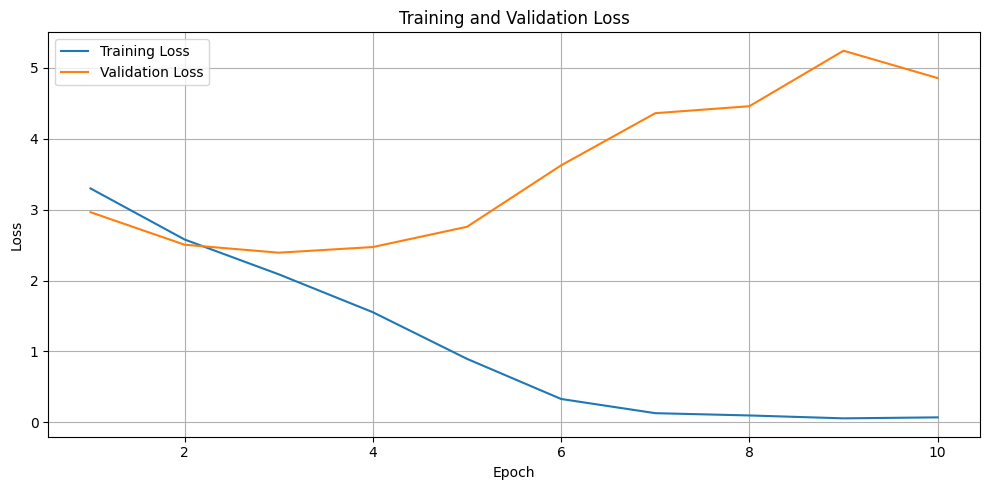

In [21]:
epochs = range(1, len(model.training_losses) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, model.training_losses, label='Training Loss')
plt.plot(epochs, model.validation_losses[1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

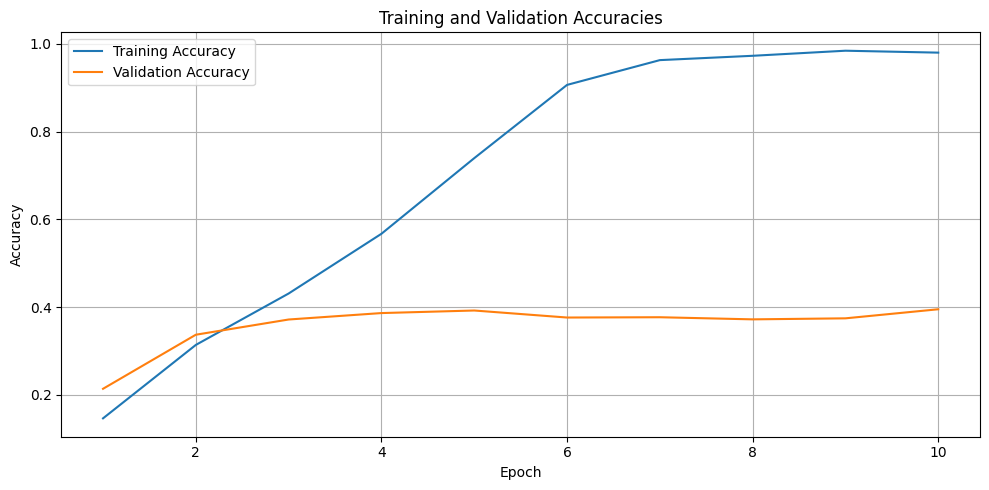

In [22]:
epochs = range(1, len(model.training_accuracies) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, model.training_accuracies, label='Training Accuracy')
plt.plot(epochs, model.validation_accuracies[1:], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()